#### Importando as bibliotecas

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

#### Carregando os dados

In [44]:
# importando os dados
df = pd.read_csv(r'Dados\airlines.csv', sep=',')

In [45]:
# analisando as primeiras linhas
df.head(3)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0


In [46]:
df.shape

(539382, 8)

#### Analisando a consistência dos dados

Vamos validar se o dataset contém dados nulos e valores duplicados

In [47]:
# Analisando valores nulos
df.isnull().sum().sum()

0

Conforme analisado, não temos nenhum valor nulo na base de dados.

In [48]:
duplicated_cols = []
for col in df.columns:
    if df[col].duplicated().any():
        duplicated_cols.append(col)
print(duplicated_cols)

['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Class']


Conforme a análise sobre os valores duplicados, podemos considerar o comportamento normal pois podemos ter vários casos com o mesmo valor na base.

#### Análise exploratória dos dados

In [49]:
df.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


Inferência:

- Média de duração de voos é de 133
- Desvio padrão é 70

Se o desvio padrão é baixo em relação à média, isso significa que a maioria dos valores estão próximos da média e que os dados estão mais concentrados em torno da média.

Vejamos em forma gráfica:

Vamos analisar o tempo do vôo utilizando um gráfico de violin em conjunto com boxplot:

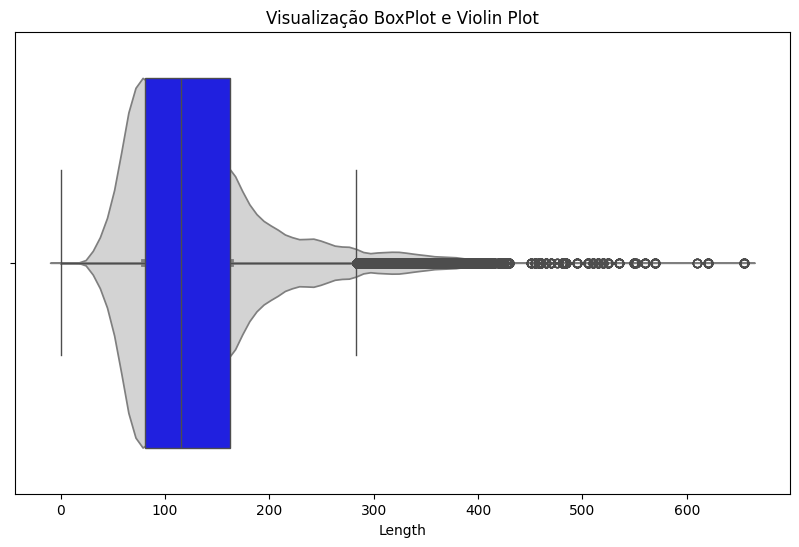

In [50]:
# Podemos mesclar o boxplot e o violin para entender nossos valores discrepantes
fig, ax = plt.subplots(figsize=(10, 6))
#Configurando o violin
sns.violinplot(data=df, x='Length', ax=ax, color='lightgray')
# Configurando o boxplot
sns.boxplot(data=df, x='Length', ax=ax, color='blue')
ax.set_title('Visualização BoxPlot e Violin Plot')

plt.show()

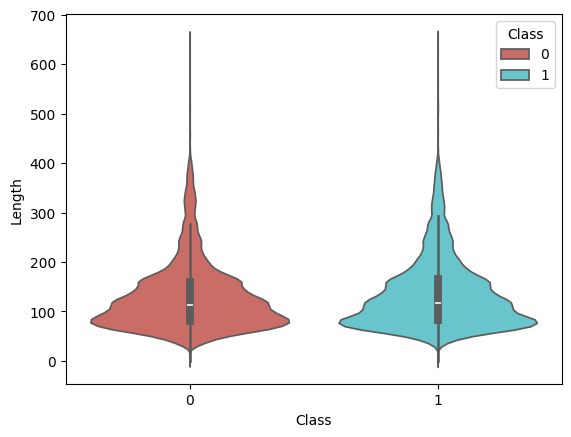

In [51]:
sns.violinplot(data=df, x='Class', y='Length', hue='Class', palette='hls')
plt.show()

Perceba que a distribuição dos dados entre as classes de atraso sim e não são bem parecidas. Vamos olhar a média de duração dos voos um pouco mais de perto.

In [52]:
atraso_voo = df.groupby('Class')
atraso_voo.describe().T

Class                        0              1
Flight    count  299118.000000  240264.000000
          mean     2513.484842    2321.413508
          std      2102.883185    2017.368082
          min         1.000000       1.000000
          25%       725.000000     701.000000
          50%      1924.000000    1695.000000
          75%      3931.000000    3408.000000
          max      7812.000000    7814.000000
Time      count  299118.000000  240264.000000
          mean      765.235138     849.405308
          std       283.712464     263.472137
          min        10.000000      10.000000
          25%       515.000000     640.000000
          50%       735.000000     860.000000
          75%       998.000000    1060.000000
          max      1439.000000    1439.000000
Length    count  299118.000000  240264.000000
          mean      129.657760     135.369697
          std        68.693953      71.723475
          min         0.000000       0.000000
          25%        81.000000      82.000000
          50%       114.000000     118.000000
          75%       159.000000     166.000000
          max       655.000000     655.000000
DayOfWeek count  299118.000000  240264.000000
          mean        3.974622       3.873697
          std         1.907565       1.922004
          min         1.000000       1.000000
          25%         2.000000       2.000000
          50%         4.000000       4.000000
          75%         5.000000       5.000000
          max         7.000000       7.000000

Analisando as estatísticas acima, perceba que a variável time é mais discrepante que a Length. Vamos plotar mais gráficos para analisar o comportamento de Time.

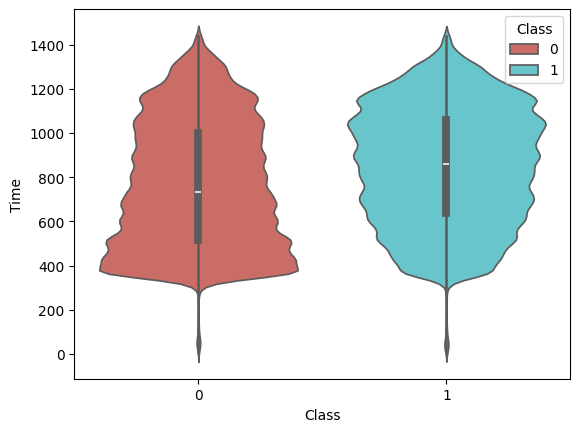

In [53]:
sns.violinplot(x='Class', y='Time', data=df, hue='Class', palette='hls')
plt.show()

Analisando as companhias x atrasos dos voos.

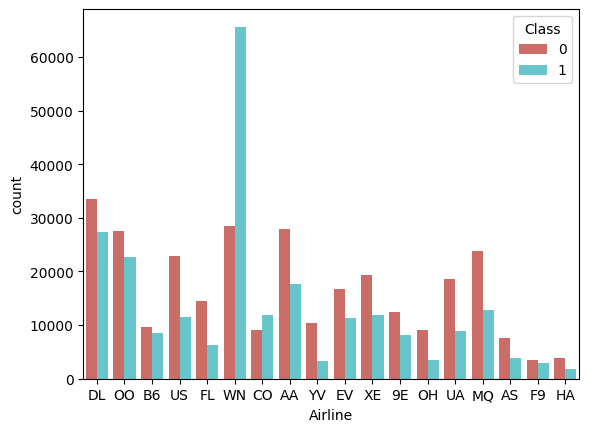

In [54]:
sns.countplot(x='Airline', hue='Class', data=df, palette='hls')
plt.show()

Inferência sobre os dados:

Podemos observar que todas as companhias aéreas possuem a classe de atraso, porém são menos do que os voos sem atraso. Apenas a companhia WN possui um número grande de atrasos, ultrapassando o total de voos realizados em tempo.

Vamos analisar os dias da semana que possuem maior concentração de atrasos.

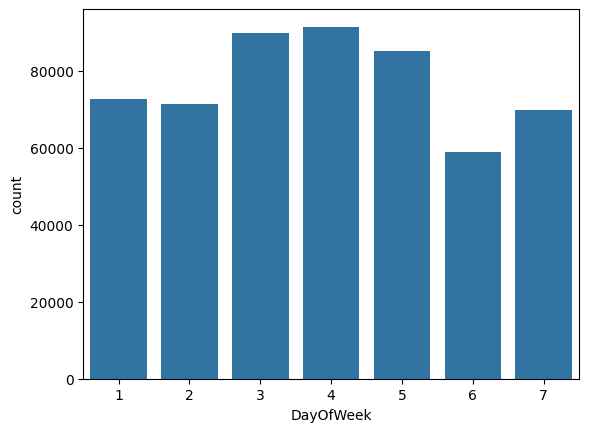

In [55]:
dia_semana = list(range(1, 8))
sns.countplot(data=df, x='DayOfWeek', order=dia_semana)
plt.show()

Vamos analisar se a base está equilibrada com o número de atrasos e não atrados:

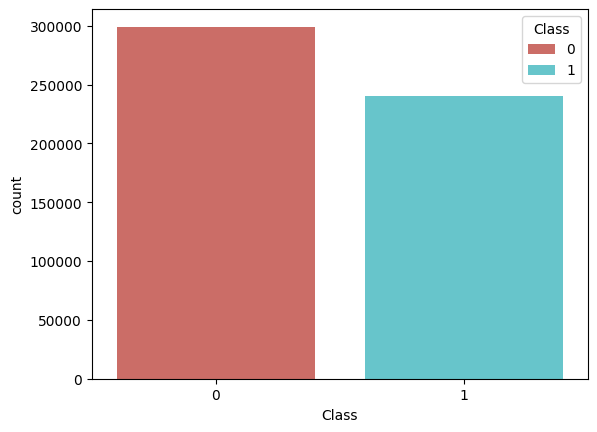

In [56]:
sns.countplot(data=df, x='Class', hue='Class', palette='hls')
plt.show()

Observe que aqui podemor ter um problema ao construir um modelo de classificação. A base de dados não está equilibrada e a falta de equilíbrio de dados pode deixar o algoritmo enviesado.

Esse tipo de problema é chamado de 'desbalanceamento de classes'.

Quando uma classe é muito mais frequente que as outras no conjunto de dados, o modelo tende a dar mais importância a essa classe, o que pode levar a uma classificação incorreta das classes minoritárias.

Vamos criar uma classificador utilizando os dados desbalanceados e vamos analisar o que pode acontecer no modelo de machine learning.

#### Pré-processamento da base

Para utilizar a companhia aérea dentro do modelo, vamos realizar a transformação de label encoding nos dados.

In [57]:
df.head(3)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0


In [58]:
df['AirportFrom']=LabelEncoder().fit_transform(df['AirportFrom'])
df['AirportTo']=LabelEncoder().fit_transform(df['AirportTo'])
df['Airline']=LabelEncoder().fit_transform(df['Airline'])

In [59]:
df.head(3)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,5,16,129,1,0
1,6948.0,360.0,146.0,12,65,208,4,0
2,1247.0,1170.0,143.0,3,35,60,3,0


#### Separando a base de dados

In [61]:
x = df[['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']]
y = df['Class']

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

#### Criando o modelo de naive bayes

Naive Bayes é um algoritmo baseado no teorema de Bayes e na suposição de independência condicional entre atributos.

O modelo Naive Bayes calcula a probabilidade condicional de uma determinada classe, dada uma entrada de dados ou conjunto de atributos, utilizando a regra de Bayes.

Ele assume que os atributos de entrada são independentes entre si, ou seja, a presença ou ausência de um atributo não é afetada pela presença ou ausência de outro atributo

In [64]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [65]:
# Predizendo valores
y_pred = gnb.predict(x_test)

#### Validando o modelo

In [67]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {round(accuracy, 2)}')

Acurácia: 0.59


De modo geral, o modelo não obteve um poder preditivo grande...

Nesse caso, podemos encontrar alguns desafios (limitações) sobre os modelos classificadores.

Podemos ter alguns impedimentos que podem ocasionar resultados ruins em nossos algoritmos, sendo eles: Algoritmos ruins ou dados ruins.

Quantidade insuficiente de dados: Com uma amostra de dados muito pequena, existirá um "ruído de amostragem" e se houver uma amostra muito grande com dados não representativos, o método de amostragem também pode ser falho (Viés de amostragem)

Dados de treinamento não representativos: O objetivo de um bom modelo de aprendizado de máquina é generalizar bem a partir dos dados de treinamento, sendo assim, é importante buscar uma base de dados representativa.

Dados de baixa qualidade: Aqui é preciso se dedicar a limpeza dos dados, uma base não consistente pode impactar na detecção de padróes.

Características irrelevantes: Entra lixo, sai lixo. Atenção aos dados que entram no seu modelo! A dica é a dedicação na etapa de feature engineering ou técnicas de redução de dimensionalidade.

#### Equilibrando a base dedados

Para equilibrar a base de dados, podemos utilizar algumas técnicas como por exemplo a biblioteca resample do sklearn.utils, utilizando o oversampling.

O oversampling é o processo de duplicar ou criar novas amostras da classe minoritária, enquanto o undersampling é o processo de remover algumas amostras da classe majoritária.

Vamos analisar como nosso resultado pode ter um upgrade com oversampling?

In [73]:
# separando as classes majoritárias e minoritárias
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

display(df_majority.shape)
display(df_minority.shape)

(299118, 8)

(240264, 8)

In [74]:
# Upsampling da classe minoritária
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=7)

In [75]:
# juntando os dois DataFrames
df_equilibrado = pd.concat([df_majority, df_minority_upsampled])

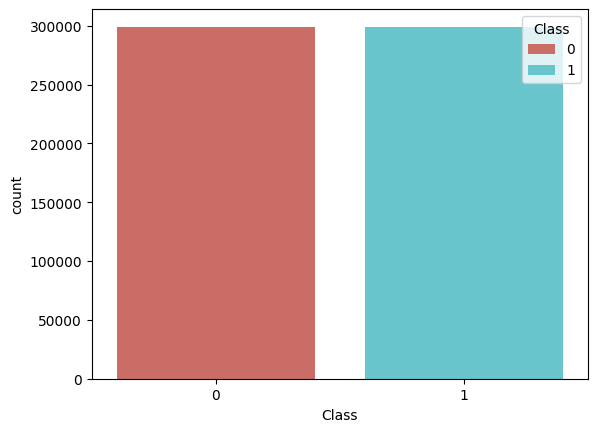

In [77]:
sns.countplot(data=df_equilibrado, x='Class', hue='Class', palette='hls')
plt.show()

Agora sim, temos uma base de dados equilibrada

#### Testando o algoritmo com a base equilibrada

In [78]:
x_equilibrado = df_equilibrado[['Flight', 'Time', 'Length', 'DayOfWeek']]  
y_equilibrado = df_equilibrado['Class']  

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x_equilibrado, y_equilibrado, test_size=0.3, stratify=y_equilibrado, random_state=7)

In [80]:
# Treinando o algoritmo
gnb_equilibrado = GaussianNB()
gnb_equilibrado.fit(x_train, y_train)

GaussianNB()

In [81]:
# Predizendo valores
y_pred_gnb_equilibrado = gnb_equilibrado.predict(x_test)

#### Validando o modelo equilibrado

In [83]:
accuracy = accuracy_score(y_test, y_pred_gnb_equilibrado)
print(f'Acurácia: {round(accuracy, 2)}')

Acurácia: 0.57


Também não tivemos muito avanço. Nesse caso, quando todas as alternativas não dão certo podemos tentar buscar novas alternativas utilizando outros algoritimos de machine learning.

Um pouco sobre algoritmos ruins:

- Sobreajuste nos dados (overfiting): Quando o seu modelo funciona muito bem com os dados de treinamento mas não generaliza bem novos dados de entrada. Isso pode acontecer quando o modelo é muito complexo em relação ao ruído de quantidade. Como solução pode-se pensar em:
    - Simplificar o modelo
    - Coletar mais dados
    - Reduzir o ruído (exemplo: remover outliers)
    - Regularização: Chamamos de regularização quando restringimos um modelo para simplificar e reduzir o risco de ajuste dos dados. A regularização pode ajudar a generalizar melhor o modelo em novos exemplos de dados.

- Subajuste dos dados (underfiting): Nesse caso seu modelo ficou muito simples ao ponto de não aprender corretamente os dados.
    Algumas soluções:
    - Selecionar um modelo mais poderoso
    - Feature engineering
    - Reduzir as regularizações

#### Testando com Random Forest

O modelo de Random Forest cria de forma aleatória várias árvores de decisão (Decision Trees) e combina o resultado de todas elas para chegar no resultado final.

Vamos analisar se combinar uma base de dados equilibrada com um algoritmo diferente e poderoso de classificação pode melhorar nossos resultados.

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x_equilibrado, y_equilibrado, test_size=0.3, random_state=7)

In [86]:
# Instacia o modelo Random Forest e define os parâmetros
rf = RandomForestClassifier(random_state=7)

In [87]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=7)

In [88]:
y_pred_rf = rf.predict(x_test)

#### Validando o modelo Random Forest

In [89]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia: {round(accuracy, 2)}')

Acurácia: 0.69
